In [1]:
%matplotlib inline
import graphlab
import graphlab.aggregate as agg
import numpy as np
import matplotlib.pyplot as plt  
import string
import re
from stemming.porter2 import stem

stopwords = graphlab.text_analytics.stopwords()

plt.style.use('ggplot')

In [2]:
sf = graphlab.SFrame('./data/boardgames-comments')

[INFO] This non-commercial license of GraphLab Create is assigned to djwelch666@googlemail.comand will expire on September 24, 2016. For commercial licensing options, visit https://dato.com/buy/.

[INFO] Start server at: ipc:///tmp/graphlab_server-46360 - Server binary: c:\users\david\.virtualenvs\py\lib\site-packages\graphlab\unity_server.exe - Server log: C:\Users\David\AppData\Local\Temp\graphlab_server_1443554175.log.0
[INFO] GraphLab Server Version: 1.6.1


In [3]:
sf = sf[sf['rating'] != 'null']
sf.add_column(sf.select_column('rating').apply(lambda x: float(x)), 'rating_float')
sf.remove_column('rating')
sf['rating'] = sf['rating_float']
sf.remove_column('rating_float')

boardgameid,text,username,rating
26717,Fascinating approach tothe different technology ...,armyduck95,7.0
26717,"In this modern version,Tech Level differenti ...",hnishy63,6.0
26717,Good modern platoon levelrules ...,JohnHBiedenkapp,9.0
26718,This game is well-designed for a Monopoly ...,espoon82,6.0
26718,I have not played thisversion of Monopoly. My ...,The Unbeliever,4.0
26721,Played in southernFinland. Didn't grow up ...,Jon_Tzu,5.0
26721,Public Domain card game.,Nap16,4.0
26721,Three player Huutopussitakes forever but four ...,oskari,6.0
26721,To quote a phrase used bycard historian David ...,sundaysilence,6.0
26722,"Playing a game with 6people, so have two ...",Insane Foxx,9.0


In [80]:
trimmed_text = sf['text'].apply(lambda x: re.sub(r'[^\sA-Za-z\P{P}]+', r' ', re.sub(r'-', r' ', x)))
trimmed_text = trimmed_text.apply(lambda x: string.join([stem(w.lower()) for w in x.split() if w not in stopwords]))
sf['word_count'] = graphlab.text_analytics.count_words(trimmed_text) # .dict_trim_by_keys(stopwords, exclude=True)

In [106]:
sf['sentiment'] = sf['rating'] >= 5

In [84]:
sf.head(2)

Columns:
	boardgameid	int
	text	str
	username	str
	rating	float
	word_count	dict
	ngram_count	dict
	word_count2	dict
	sentiment	int

Rows: 2

Data:
+-------------+-------------------------------+------------+--------+
| boardgameid |              text             |  username  | rating |
+-------------+-------------------------------+------------+--------+
|    26717    | Fascinating approach to th... | armyduck95 |  7.0   |
|    26717    | In this modern version, Te... |  hnishy63  |  6.0   |
+-------------+-------------------------------+------------+--------+
+-------------------------------+-------------------------------+
|           word_count          |          ngram_count          |
+-------------------------------+-------------------------------+
| {'control': 1L, 'play': 1L... | {'singl game': 1L, 'haven ... |
| {'rang': 1L, 'point': 1L, ... | {'version tech': 1L, 'one ... |
+-------------------------------+-------------------------------+
+-------------------------------+-----------+
|          word_count2          | sentiment |
+-------------------------------+-----------+
| {'control': 1L, 'play': 1L... |     1     |
| {'rang': 1L, 'point': 1L, ... |     1     |
+-------------------------------+-----------+
[2 rows x 8 columns]

In [81]:
word_counts = {}
for wc in sf['word_count']:
    for key, value in wc.items():
        word_counts[key] = (word_counts[key] if key in word_counts else 0) + value
word_counts_sf = graphlab.SFrame({'word': [ k for k, v in word_counts.items()], 'count': [ v for k, v in word_counts.items()] })

In [82]:
word_counts_sf.sort('count', False).print_rows(100)

+--------+----------+
| count  |   word   |
+--------+----------+
| 642906 |   game   |
| 422192 |    i     |
| 314040 |   play   |
| 146742 |   the    |
| 127729 |  player  |
| 124575 |   card   |
| 111862 |   fun    |
| 97415  |   good   |
| 86205  |    it    |
| 77231  |   rule   |
| 71593  |   time   |
| 71166  |    a     |
| 67582  |  great   |
| 64476  |   make   |
| 62657  |   this   |
| 53904  |   lot    |
| 52633  | interest |
| 51736  |   nice   |
| 42655  |   bit    |
| 39660  |   rate   |
| 39558  |   don    |
| 37955  |  enjoy   |
| 37072  |  mechan  |
| 36503  |  expans  |
| 36256  |   turn   |
| 35125  |   love   |
| 34914  |  theme   |
| 34389  |   feel   |
| 32694  |  board   |
| 31946  |  simpl   |
| 31716  |  point   |
| 31564  |   kid    |
| 30194  |   not    |
| 29980  |   set    |
| 29428  |   work   |
| 29051  |   dice   |
| 28604  |  quick   |
| 28176  |   base   |
| 27894  |  thing   |
| 27604  |   move   |
| 26712  | strategi |
| 26292  |   add    |
| 26024  |

In [132]:
sf['word_count2'] = sf['word_count'].dict_trim_by_keys(word_counts_sf[word_counts_sf['count'] <= 100]['word'])

In [133]:
data = sf[sf['text'].apply(lambda x: len(x.split()) > 5)]

In [134]:
train_data, test_data = data.random_split(0.8, seed=0)

In [135]:
sentiment_model = graphlab.logistic_classifier.create(train_data, 
                                                      target='sentiment', 
                                                      features=['word_count2'], 
                                                      #l1_penalty = 0.1,
                                                      #l2_penalty = 0.5,
                                                      validation_set=test_data)

PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 422308
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 1
PROGRESS: Number of unpacked features : 5972
PROGRESS: Number of coefficients    : 5973
PROGRESS: Starting L-BFGS
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 4        | 0.000001  | 0.825107     | 0.842821          | 0.843801            |
PROGRESS: | 2         | 8        | 3.000000  | 1.815805     | 0.851942          | 0.853042            |
PROGRESS: | 3         | 9        | 3.000000  | 2.213084     | 0.757772

In [116]:
coefficients = sentiment_model['coefficients']
coefficients.sort('value', False).print_rows(100)

+-------------+-------------+-------+----------------+
|     name    |    index    | class |     value      |
+-------------+-------------+-------+----------------+
| word_count2 |    underr   |   1   | 1.46574172625  |
| word_count2 |    alway    |   1   | 1.23213042918  |
| word_count2 |    superb   |   1   | 1.16945926259  |
| word_count2 |    addict   |   1   | 1.16880330575  |
| word_count2 |    tricki   |   1   | 1.15123817109  |
| word_count2 |    tentat   |   1   | 1.14116540504  |
| word_count2 |    excel    |   1   | 1.06810529937  |
| word_count2 |     must    |   1   | 1.05153426024  |
| word_count2 |   delight   |   1   | 1.04457367841  |
| (intercept) |     None    |   1   | 1.02402568372  |
| word_count2 |     best    |   1   | 1.01713338549  |
| word_count2 |    solid    |   1   | 1.00387211181  |
| word_count2 | preliminari |   1   | 0.99970199521  |
| word_count2 |     tens    |   1   | 0.988695148881 |
| word_count2 |  brilliant  |   1   | 0.987376732032 |
| word_cou

In [91]:
data.groupby(key_columns='boardgameid', operations={ 'count': agg.COUNT() }).topk('count', 10)

boardgameid,count
22545,84
142965,84
7062,82
13123,82
96848,82
14188,82
37111,82
19777,82
22345,81
34297,81


In [92]:
reviews = data[data['boardgameid'] == 22545]

In [117]:
reviews['p'] = sentiment_model.predict(reviews, output_type='probability')

In [118]:
reviews = reviews.sort('p', False)

In [119]:
len(reviews)

84

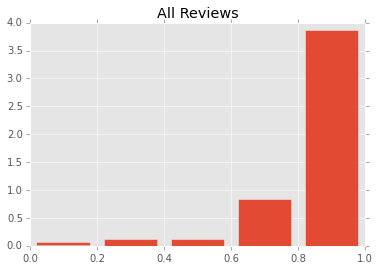

In [120]:
X = reviews['p']
bins = [0,0.2,0.4,0.6,0.8,1.0]
plt.hist(X, bins, normed=1, histtype='bar', rwidth=0.8)
plt.title('All Reviews')

In [131]:
reviews[1]['text']

"Even though I don't play it as often as I'd like AoE III is always a fantastic experience. It scales well 2-5 players, though is very different for each. It's a Euro, but with the sense of an evolving story; just enough randomness, lots of different strategies to explore, and lots of tough tactical decisions as the slots for worker placement fill up. I love it, and really want to play more often!\n\nMy criticisms are to do with the components: a useless scoring track, the necessity of printing some BGG play aids (easily done, that one), and the difficulty of telling the (rather garishly coloured) pieces apart. The game is good enough to overcome these problems, but a new edition where they were fixed would be truly outstanding.\n\n...\n\nYears on, although I still play fairly infrequently I still love it, really enjoy it every time I play."